# Entity aggregation using filters and BERTopic

In [1]:
from utils import *
from bertopic import BERTopic

## Load the data
This data should contain the following:
1. A sentence (key: sentence),
2. The paragraph the sentence was extracted from (key: paragraph),
3. An extracted phase (key: phase),
4. An extracted property (key: property),
5. A relationship between phase and property, either "positive" or "negative (key: relationship).

In [ ]:
sentence_data_raw = np.load(f"data/YOUR_DATA_HERE.npy", allow_pickle=True)

# Lower everything to make sure that we don't have to deal with capitalisation
for s in sentence_data_raw:
    s['phase'] = s['phase'].lower()
    s['property'] = s['property'].lower()
    s['relationship'] = s['relationship'].lower()

## Change entity strings and discard unwanted ones

In [ ]:
with open("data/elem_name_dict.json", "r") as f:
    elem_names_dict = json.load(f)
elem_names_dict['aluminum'] = 'Al' # Add American spelling of aluminium
elem_names_dict = {k.lower(): v.lower() for k, v in elem_names_dict.items()}
  
# And word here is going to be removed from the string
soft_stop_words_phase = [
    'precipitate', 'precipitates', 'intermetallic', 'intermetallics', 'particle', 'particles',
    'dispersoid', 'dispersoids', 'nanoparticle', 'nanoparticles', 'precipitation', 'precipitations',
    'strengthening', 'particulates', 'particulate', 'hardening', 'phase', 'phases', 'second', 'secondary',
    'coherent', 'amorphous', 'content', 'solution', 'crystalline', 'fine', 'needles', 'clusters'
]

# Any word in here will delete the entire datapoint (sentence, phase, property, relationship)
hard_stop_words_phase = [
    'alloy', 'alloys', 'composite', 'composites', 'nanotube', 'nanotubes', 'nano-tube', 'nano-tubes',
    'cnt', 'cnts', 'grain', 'zone', 'zones', 'GP', 'GPB', 'reinforcements', 'reinforcement', 'metastable',
    'ceramic', 'ceramics', 'brittle', 'fiber', 'fibers', 'microfiber', 'microfibers', 'nano', 'solid fraction', 'small'
]

# Similarly for properties
soft_stop_words_prop = []

hard_stop_words_prop = ['cost', 'efficiency']

In [ ]:
sentence_data_cleaned = remove_change_words_phase(sentence_data_cleaned, hard_stop_words_phase, soft_stop_words_phase, elem_names_dict)
sentence_data_cleaned = remove_change_words_prop(sentence_data_cleaned, hard_stop_words_prop, soft_stop_words_prop)

## Group phases by chemical formulae

In [ ]:
# chem_names should be a list of lists with the different ways to write the formla of certain phases
chem_names = [
    ['mg2si'], ['al3sc'], ['al2cu', 'cual2'], ['al3zr'], ['mgzn2'],
    ['al3\(sc,zr', 'al3\(sc, zr', 'al3\(zr,sc', 'al3\(zr, sc'], ['al2culi'], ['al2cumg', 'cumgal2'], ['al3li'],
    ['al5fesi', 'alfesi'], ['mg2al3', 'al3mg2'], ['al6mn', 'mnal6'], ['al12mg17', 'mg17al12'], ['al8fe2si'], ['b4c']
]

In [ ]:
sentence_data_cleaned = merge_chem_names(sentence_data_cleaned, chem_names)

## Group entities into standardised names

In [2]:
# This maps one phase name into another
phase_map = {
    'al2culi': 't1-al2culi', 't1': 't1-al2culi', 'alumina': 'al2o3', 'si carbide': 'sic', 'sicp': 'sic',
    'si [to_keep]': 'si', 'al2cu': 'θ-al2cu', 'θ': 'θ-al2cu', 'b carbide': 'bc', 'e': 'η-mgzn2',
    'si nitride': 'si3n4', 'al5fesi': 'β-al5fesi', 'fe rich': 'fe-rich', 'mg2si': 'β-mg2si', 'η': 'η-mgzn2',
    'mgzn2': 'η-mgzn2', 'ω': 'ω-al2cu', 'al2cumg': 's-al2cumg', 's': 's-al2cumg', 'α alumina': 'α-al2o3',
    'α al2o3': 'α-al2o3', 'q': 'q-alcumgsi', 'mg2al3': 'β-al3mg2', 'al3ni': 'ε-al3ni', 't': 't-al2mg3zn3',
    'al2mg3zn3': 't-al2mg3zn3', 'al3li': 'δ-al3li', 'al3\\(sc,zr': 'al3(sc,zr)', 'meta-mgzn2': "η'",
    'meta-al2cumg': "s'", 'meta-al3zr': "β'-al3zr", 'doublemeta-mg2si': "β''", 'meta-mg2si': "β'",
    'al3(sc1 xzrx)': 'al3(sc,zr)', 'meta-al3li': "δ'", 'meta-al2cu': "θ'", 'α': 'α-Al', 'fcc al': 'α-Al',
    'a al2o3': 'α-al2o3', 'α al': 'α-al', 'fe containing': 'fe-rich', 'feal3': 'al3fe', 'fe bearing': 'fe-rich',
    'fe2al5': 'al5fe2', 'acicular si': 'si', 'al3scxzr1 x': 'al3(sc,zr)', "γ al2o3": "γ-al2o3", "cu rich": "cu-rich",
    "al8fe2si": "α-al8fe2si", "β'' phase": "β''", 'a al': 'α-al', 'tial3': "al3ti", 'q al5cu2mg8si6': 'q-alcumgsi',
    "mg9si5": "β'", "al2mg5si4": "β''", "g'": "γ'", '\\( {{\\η}}\\prime \\)': "η'", 'g al2o3': 'γ-al2o3',
    'al3 (sc, zr)': 'al3(sc,zr)', 'primary α al': 'α-al', "al3sc1-xzrx": 'al3(sc,zr)', "al3sc1zr1-x": 'al3(sc,zr)'
}
phase_map = {k.lower(): v.lower() for k, v in phase_map.items()}

# After the initial cleaning, we still get more undesired phases, we remove those
phase_to_remove = [
    'precipitates', 'particles', 'dispersoids', 'porosity', 'al', 'precipitations', 'solid solution', 'strengthening',
    'phases', 'compounds', 'hardening', 'fine', 'coarse', 'phase', 'carbide', 'carbides', 'matrix',
    'al solid solution', 'eutectic', 'primary', 'pfz', 'imc', 'imcs', 'graphite', 'constituent', 'al matrix',
    'nanoscale', 'hard', 'clusters', 'oxide', 'nano', 'oxides', 'precipitated', 'alloying elements',
    'dendrites', 'pores', 'microporosity', 'al cu', 'al si', 'zirconia', 'high si content', 'almg', 'liquid',
    'quasicrystalline', 'intragranular', 'pfzs', 'hagbs', 'icosahedral', 'reinforcing', 'inclusions', 'almn',
    'almgsi', 'almnsi', 'al mg si', 'fine grains', 'dispersed', 'transition metals', 'al fe', 'whiskers', 'excess si',
    'needle shaped', 'lagbs', 'ptfe', 'thermally stable', 'coarse grains', 'gbps', 'si content', 'al zn mg',
    'alcumg', 'soft', 'al zn mg cu', 'feal', 'work', 'al cu mg'
]
phase_to_remove = [p.lower() for p in phase_to_remove]

# Idem for properties
prop_map = {}
prop_map = {k.lower(): v.lower() for k, v in prop_map.items()}

prop_to_remove = ['properties', 'property', 'performance', 'mechanical', 'grain refinement']
prop_to_remove = [p.lower() for p in prop_to_remove]

In [ ]:
sentence_data_cleaned = remove_change_full(sentence_data_cleaned, elem_names_dict, phase_to_remove, phase_map, prop_to_remove, prop_map)

## Split the mentions of the phases with the same name
In the case of aluminium alloys, only the beta phase can represent different phases.

In [14]:
# This is a list of possible chemical formulae of the beta phase
# We will search for those in the sentence and paragraph to determine the exact phase
possible_beta = {
    'AlFeSi': 'β-al5fesi', 'Al5FeSi': 'β-al5fesi',
    'Al3Mg2': 'β-al3mg2', 'Mg2Al3': 'β-al3mg2', 'Mg2Si': 'β-mg2si'
}

In [ ]:
sentence_data_cleaned = check_beta_paragraphs(sentence_data_cleaned, possible_beta)

## Topic modelling for properties
For the properties, we perform seeded topic modeling using BERTopic.

In [12]:
to_cluster = list(set([s["property"] for s in sentence_data_cleaned]))

seeds = [
    ['microhardness', 'hardness'],
    ['strengthening', 'hardening', 'age hardening'],
    ['elongation', 'ductility', 'plasticity'],
    ['toughness', 'fracture toughness'],
    ['specific strength', 'high temperature strength', 'mechanical strength', 'strength', 'high strength'],
    ['strain hardening', 'work hardening'],
    ['brittleness', 'brittle'],
    ['corrosion', 'intergranular corrosion'],
    ['stiffness', 'elastic modulus'],
    ['uts/ys', 'elevated temperature ultimate tensile strength', 'ultimate tensile strength (uts)',
     'ultimate strength', 'uts', 'tensile strength (uts)', 'ultimate tensile strength', 'ultimate rupture strength'],
    ['mechanical properties'],
    ['corrosion resistance'],
    ['wear resistance'],
    ['tensile strength'],
    ['yield strength'],
    ['microhardness'],
    ['precipitation hardening'],
    ['tensile properties'],
    ['age hardening'],
    ['toughness'],
    ['creep resistance'],
    ['elongation'],
    ['thermal stability'],
    ['mechanical strength'],
    ['formability'],
    ['brittle'],
    ['elastic modulus'],
    ['castability'],
    ['fatigue strength'],
    ['tribological properties'],
    ['plasticity']
]

In [243]:
# Run model and get topics
topic_model = BERTopic(seed_topic_list=seeds)
topics, probs = topic_model.fit_transform(to_cluster)

In [248]:
# Get results and save them
res = topic_model.get_document_info(to_cluster)
res.to_csv("data/bertopic_res_seeded.csv")

<AxesSubplot:>

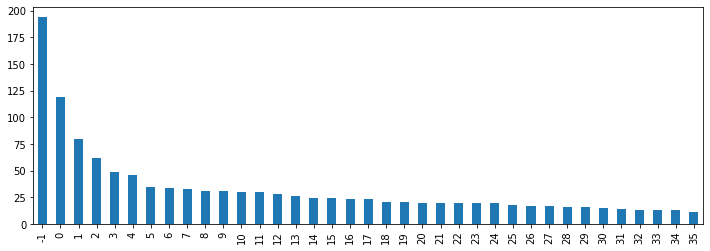

In [15]:
# Read saved results and plot the topic histogram
res = pd.read_csv("data/bertopic_res_seeded.csv", index_col=0)

res['Topic'].value_counts().plot.bar(figsize=(12, 4))

In [18]:
# Only works for the paper data
# List of manual labels, "misc" will be discarded
topic_names_map = {
    '-1_hydrogen_hot_tribological_electrochemical': "misc",
    '0_properties_mechanical_surface_anisotropy': "mechanical properties",
    '1_strength_shear_weight_load': "strength",
    '2_wear_resistance_abrasive_sliding': "wear",
    '3_thermal_stability_heat_expansion': "thermal stability",
    '4_hardening_strain_bake_solution': "hardening",
    '5_elongation_nucleation_shrinkage_spheroidization': "elongation",
    '6_fatigue_cycle_crack_endurance': "fatigue",
    '7_corrosion_intergranular_galvanic_inter': "corrosion",
    '8_recrystallization_precipitation_hardening_precipitate': "hardening",
    '9_corrosion_oxidation_inhibition_durability': "corrosion",
    '10_resistance_corrosion_pitting_chloride': "corrosion",
    '11_igc_susceptibility_scc_igcscc': "corrosion",
    '12_plastic_plasticity_packaging_transparency': "plastic properties",
    '13_temperature_melting_high_temperatures': "high T properties",
    '14_toughness_failure_problems_sth': "misc",
    '15_tensile_strength_uts_cohesion': "tensile properties",
    '16_hardness_porosity_micro_si': "hardness",
    '17_age_aging_hardening_ageing': "hardening",
    '18_grain_refining_boundary_structure': "grain properties",
    '19_stress_rupture_concentration_raisers': "stress",
    '20_ductility_tensile_ductile_axial': "tensile properties",
    '21_fracture_toughness_compatibility_bone': "fracture properties",
    '22_brittle_dissolution_solubility_solid': "brittleness",
    '23_crack_cracking_propagation_formation': "fracture properties",
    '24_formability_workability_drawbacks_decomposition': "formability",
    '25_modulus_elastic_elasticity_specific': "tensile properties",
    '26_casting_cast_feedability_integrity': "castability",
    '27_creep_life_diffusional_shielding': "creep",
    '28_yield_ratio_strength_density': "yield strength",
    '29_effects_harmful_beneficial_negative': "misc",
    '30_dislocation_pinning_slip_obstruction': "strength",
    '31_softening_cyclic_aging_hardening': "misc",
    '32_brittle_brittleness_phase_chip': "brittleness",
    '33_microhardness_segregation_evolution_smet': "misc",
    '34_deformation_deformability_localization_intercrystalline': "deformability",
    '35_electrical_insulator_conductivity_molten': "electrical properties"
}

In [19]:
# Change the properties based on the list above
sentence_data_cleaned_aggr = []

for s in sentence_data_cleaned:
    topic_name = res[res['Document'] == s["property"]]['Name'].values[0]
    s_copy = copy.deepcopy(s)
    
    if topic_names_map[topic_name]!='misc':
        
        s_copy["property"] = topic_names_map[topic_name]
        
        if topic_names_map[topic_name]=='corrosion' or topic_names_map[topic_name]=='wear':
            if 'resistance' in s_copy['property_orig'] or 'resistant' in s_copy['property_orig']or 'protection' in s_copy['property_orig']:
                s_copy[cluster_dim] = f"{topic_names_map[topic_name]} resistance"
                
        if topic_names_map[topic_name]=='tensile properties' or topic_names_map[topic_name]=='strength':
            if 'ultimate' in s_copy['property_orig']:
                s_copy[cluster_dim] = f"UTS"
                
        del s_copy['paragraph']
        del s_copy['phase_orig']
        del s_copy['property_orig']
        
        sentence_data_cleaned_aggr.append(s_copy)